In [501]:
# raytracing tutorial
# 17 - scene with fog

In [502]:
import numpy
import matplotlib.pyplot as plt
import math

import random

from opensimplex import OpenSimplex

# plot images in this notebook
%matplotlib inline

In [503]:
# axes x to the right, y upwards. z into the screen (left hand rule)

In [504]:
# texture function, takes coordinates, returns colour

noise_generator = OpenSimplex()

def texture_noise(location):
    x = location[0]
    y = location[1]
    z = location[2]
    
    colour = numpy.array([noise_generator.noise3d(x*10,y*10,z*10) + 1.0,
                          noise_generator.noise3d(x*10,y*10,z*10) + 1.0,
                          noise_generator.noise3d(x*10,y*10,z*10) + 1.0])
    
    return colour

In [505]:
# sphere object

class Sphere():
    
    def __init__(self, centre, r, colour):
        self.name = "sphere"
        self.centre = centre
        self.radius = r
        self.colour = colour
        pass
    
    def status(self):
        print(self.name)
        print("centre = ", self.centre)
        print("radius = ", self.radius)
        print("colour = ", self.colour)
        print("")
        pass

    def intersection(self, camera_location, ray_direction_vector):
        # calculate quadratic determinant "b^2 - 4ac" for ray intersecting circle
        b = numpy.dot(2 * ray_direction_vector,(camera_location - self.centre))
        b2 = b*b
        a = numpy.dot(ray_direction_vector, ray_direction_vector)
        c = numpy.dot((self.centre - camera_location), (self.centre - camera_location)) - (self.radius * self.radius)
        delta = b2 - (4 * a * c)
        #print(delta)
        
        if (delta >= 0):
            # calculate nearest point (lowest t)
            t = (-b - math.sqrt(delta)) / (2 * a)
            intersection_point = camera_location + (t * ray_direction_vector)
            #print("sphere")
            #print("camera_location, ray_direction_vector", camera_location, ray_direction_vector)
            #print("t =", t)
            #print("intersection_point ", intersection_point)
            
            # calculate normal at surface
            normal = (intersection_point - self.centre) / numpy.linalg.norm(intersection_point - self.centre)
            
            # additional check to ensure intersection was in direction of ray, t>0
            if (t<0):
                # set delta negative as if not intersected
                delta = -1
                pass
            
            # apply texture
            ## colour = self.colour + texture_wavy(intersection_point)
            colour = self.colour + texture_noise(intersection_point)
            
            # return tuple (intersection yes/no, nearest point, normal)
            return (delta>0, intersection_point, normal, colour)
            pass
        
        # return tuple (intersection yes/no, nearest point, norm, colour)
        return (delta >= 0, 0, 0, numpy.array([0,0,0]))

In [506]:
# camera location
camera_location = numpy.array([0,20,-200])

# view port
view_port_location = numpy.array([-10, 0, 0])
view_port_width = 20
view_port_height = 20

# resolution (pixels per unit distance)
resolution = 40

In [507]:
# light source

# light is at above right, and a bit forward
light_location = numpy.array([10, 50, -50])

# ambient light factor
ambient = 0.25

# fog colour, white is fog, black is smoke
fog_enabled = True
fog_colour = numpy.array([0.5, 1.0, 0.5])

In [508]:
# scene is a list of objects
scene_objects = []

# add spheres
for x in range(-8, 9, 4):
    for z in range(-20, 160, 40):
        scene_objects.append(Sphere(numpy.array([x,10,z]), 1, numpy.array([1.0, 0.3, 0.3])))
        pass
    pass

# get status of each object
#for obj in scene_objects:
#    obj.status()
#    pass

In [509]:
# create image

image = numpy.zeros([view_port_width * resolution, view_port_height * resolution, 3], dtype='float64')
print("image shape = ", image.shape)

image shape =  (800, 800, 3)


In [510]:
# max ray tracing depth for scene
max_depth = 2

# recursive ray function
def ray(ray_origin, ray_direction, depth):
    
    # start with zero colour contribution, false intersected flag and nearest point at infinity
    colour_contribution = numpy.array([0.0,0.0,0.0])    
    intersected = False
    distance_to_nearest_point = numpy.Infinity
    nearest_obj = False
    
    for obj in scene_objects:
        
        # check intersection with object
        intersection = obj.intersection(ray_origin, ray_direction)
        
        # did it intersect?
        if intersection[0]:
            intersected = True
            
            distance_to_point = numpy.linalg.norm(intersection[1] - ray_origin)
            
            if (distance_to_point < distance_to_nearest_point):
                
                # update nearest point
                distance_to_nearest_point = distance_to_point
                point_on_nearest_obj = intersection[1]
                norm = intersection[2]
                obj_colour = intersection[3]
                nearest_obj = obj
                
                # vector to light
                to_light = light_location - point_on_nearest_obj
                to_light /= numpy.linalg.norm(to_light)
                
                # illumination factor
                cos_norm_to_lightsource = numpy.dot(to_light, norm) / numpy.linalg.norm(to_light)
                
                # reflected factor (will have norm 1)
                reflected_ray = (2 * numpy.dot(norm, to_light) * norm) - to_light
                cos_ray_to_reflection = numpy.dot(-ray_direction, reflected_ray) / (numpy.linalg.norm(reflected_ray))
            
                # clip if below zero
                cos_norm_to_lightsource = numpy.clip(cos_norm_to_lightsource, 0, 1)
                cos_ray_to_reflection = numpy.clip(cos_ray_to_reflection, 0, 1)
                
                # apply power
                cos_norm_to_lightsource = math.pow(cos_norm_to_lightsource, 2)
                cos_ray_to_reflection = math.pow(cos_ray_to_reflection, 2)
                
                # candidate colour contribution
                candidate_colour_contribution = (obj_colour * cos_norm_to_lightsource * cos_ray_to_reflection)
                pass
            
            pass
        
        #next object
        pass
    
    
    # fire off new ray if intersected and depth is within max
    if (intersected):
        
        in_shadow = False
        for obj in scene_objects:
            # enusre object isn't current object from which shadow ray starts
            if (obj != nearest_obj):
                # check intersection with object
                if obj.intersection(point_on_nearest_obj, to_light)[0]:
                    in_shadow = True
                    pass
                pass
            pass
        
        # only add colour contribution if not in shadow
        if (not in_shadow):
            # colour contribution from nearest object
            colour_contribution = candidate_colour_contribution
            pass
        
        
        # add ambient light, diminish with depth
        colour_contribution += obj_colour * ambient / (depth)
        
        # recurse colour contribution from bounced ray
        if (depth < max_depth):
            # bounced ray (from source, not from light source)
            bounced_ray = (2 * numpy.dot(norm, -ray_direction) * norm) + ray_direction
            # divide by depth to reduce strength of light after many reflections
            colour_contribution += (ray(point_on_nearest_obj, bounced_ray, depth + 1)[1] / ( depth))
            pass
        
        pass
    
    # fog    
    if (fog_enabled and (depth==1)):
        intersected = True
        x = ray_direction[0] * 200
        y = ray_direction[1] * 200
        fog_noise = (noise_generator.noise2d(x, y)  + 1) / 3.0
        #print(x, y, fog_noise)
        colour_contribution += (fog_colour * fog_noise)
        pass
    
    return (intersected), colour_contribution

In [511]:
# main loop is to consider every pixel of the viewport

for pixel_ix in range(image.shape[0]):
    print(pixel_ix, image.shape[0])
    for pixel_iy in range(image.shape[1]):
#for pixel_ix in range(20,21):
#    for pixel_iy in range(15,16):
        
        # ray direction
        current_position = view_port_location + numpy.array([pixel_ix/resolution, pixel_iy/resolution, 0])
        ray_direction = current_position - camera_location
        ray_direction /= numpy.linalg.norm(ray_direction)
        
        # pixel is set to colour contribution from (recursive) ray
        intersected, colour_contribution = ray(camera_location, ray_direction, 1)
        if (intersected):
            image[pixel_ix, pixel_iy] = colour_contribution
        else:
            image[pixel_ix, pixel_iy] = [0.3 + ray_direction[1], 0.3 + ray_direction[1], 1.0 + (ray_direction[1] * 5)]
            pass
        
        pass
    pass

0 800
1 800
2 800
3 800
4 800
5 800
6 800
7 800
8 800
9 800
10 800
11 800
12 800
13 800
14 800
15 800
16 800
17 800
18 800
19 800
20 800
21 800
22 800
23 800
24 800
25 800
26 800
27 800
28 800
29 800
30 800
31 800
32 800
33 800
34 800
35 800
36 800
37 800
38 800
39 800
40 800
41 800
42 800
43 800
44 800
45 800
46 800
47 800
48 800
49 800
50 800
51 800
52 800
53 800
54 800
55 800
56 800
57 800
58 800
59 800
60 800
61 800
62 800
63 800
64 800
65 800
66 800
67 800
68 800
69 800
70 800
71 800
72 800
73 800
74 800
75 800
76 800
77 800
78 800
79 800
80 800
81 800
82 800
83 800
84 800
85 800
86 800
87 800
88 800
89 800
90 800
91 800
92 800
93 800
94 800
95 800
96 800
97 800
98 800
99 800
100 800
101 800
102 800
103 800
104 800
105 800
106 800
107 800
108 800
109 800
110 800
111 800
112 800
113 800
114 800
115 800
116 800
117 800
118 800
119 800
120 800
121 800
122 800
123 800
124 800
125 800
126 800
127 800
128 800
129 800
130 800
131 800
132 800
133 800
134 800
135 800
136 800
137 800
138 80

In [512]:
# apply squashing function to image
# first shift data into range [0,1] asymptotically
# then remap to colour RGB range [0,255] dtype=uint8

# squash with tanh()
image = numpy.tanh(image)

# remap to RGB range
image_rgb = numpy.array(image*255, dtype='uint8')

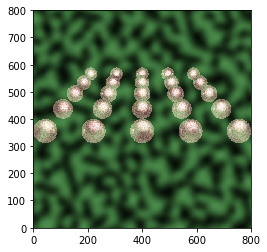

In [513]:
# transpose array so origin is bottom left, by swapping dimensions 0 and 1, but leave dimension 3

image_rgb2 = numpy.transpose(image_rgb, (1, 0, 2))
plt.imshow(image_rgb2, origin='lower')

In [514]:
plt.imsave('test.png', image_rgb2, origin='lower')